<a href="https://colab.research.google.com/github/entc-17-fyp-20/WPF_Data_Visualization/blob/Udesha-/EncoderDecoNew04_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/CEB%20new%20updated(Only%20actual).csv')
df = df.rename(columns = {'Time Stamp': 'Date & Time','Actual Total WTG Output Power /kW':'Active_Power(kW)','Forecasted Power':'Forecasted_Power(kW)'}, inplace = False)
df=df[['Date & Time','Active_Power(kW)']]
df['Date & Time'] = pd.to_datetime(df['Date & Time'], format="%m/%d/%Y %H:%M")
# df.index = df['Date & Time']
# df=df[['Active_Power(kW)']]
df=df[1:]
data=df.head(17500)

In [ ]:
# url = f"https://raw.githubusercontent.com/Apress/hands-on-time-series-analylsis-python/master/Data/Metro_Interstate_Traffic_Volume.csv"

In [ ]:
# data = pd.read_csv(url)

In [ ]:
data.head()

,Date & Time,Active_Power(kW)
1,2021-09-01 00:00:00,93793.5
2,2021-09-01 00:10:00,95265.2
3,2021-09-01 00:20:00,96545.6
4,2021-09-01 00:30:00,97879.0
5,2021-09-01 00:40:00,97867.2


In [ ]:
data.describe()

,Active_Power(kW)
count,17500.000000
mean,41696.385686
std,36667.373874
min,0.000000
25%,9960.750000
50%,28435.000000
75%,79874.475000
max,103504.000000


In [ ]:
# data.drop_duplicates(subset=['Date & Time'], keep=False,inplace=True)

In [ ]:
validate = data['Active_Power(kW)'].tail(10)
data = data.drop(data['Active_Power(kW)'].tail(10).index)

In [ ]:
uni_data = data['Active_Power(kW)']
uni_data.index = data['Date & Time']
uni_data.head()

Date & Time
2021-09-01 00:00:00    93793.5
2021-09-01 00:10:00    95265.2
2021-09-01 00:20:00    96545.6
2021-09-01 00:30:00    97879.0
2021-09-01 00:40:00    97867.2
Name: Active_Power(kW), dtype: float64

In [ ]:
uni_data = uni_data.values
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data.reshape(-1, 1))

In [ ]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
  X = []
  y = []

  start = start + window
  if end is None:
    end = len(dataset) - horizon

  for i in range(start, end):
    indicesx = range(i-window, i)
    X.append(np.reshape(dataset[indicesx], (window, 1)))
    indicesy = range(i,i+horizon)
    y.append(dataset[indicesy])
  return np.array(X), np.array(y)

In [ ]:
univar_hist_window = 48
horizon = 10
TRAIN_SPLIT = 14000
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target horizon')
print (y_train_uni[0])

Single window of past history
[[0.90618237]
 [0.92040114]
 [0.93277168]
 [0.94565427]
 [0.94554027]
 [0.94601271]
 [0.94699915]
 [0.94794404]
 [0.94803389]
 [0.95021738]
 [0.95003478]
 [0.95006087]
 [0.94936428]
 [0.95020772]
 [0.94938263]
 [0.94997681]
 [0.95031786]
 [0.94848025]
 [0.94826094]
 [0.94766966]
 [0.94924158]
 [0.95072075]
 [0.95155743]
 [0.95131396]
 [0.95153617]
 [0.95703065]
 [0.98245478]
 [0.9801428 ]
 [0.98061041]
 [0.9816268 ]
 [0.98195046]
 [0.98084808]
 [0.98117367]
 [0.98179587]
 [0.98171568]
 [0.97951867]
 [0.98080751]
 [0.98129251]
 [0.98231663]
 [0.98244416]
 [0.98242966]
 [0.98081813]
 [0.98185481]
 [0.98156013]
 [0.98092924]
 [0.97933123]
 [0.8259874 ]
 [0.55544906]]

 Target horizon
[[0.54492194]
 [0.56789013]
 [0.57568307]
 [0.57532849]
 [0.57482609]
 [0.57593523]
 [0.5751884 ]
 [0.57554877]
 [0.57395366]
 [0.57483382]]


In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 150
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
# create model
from keras.models import Sequential
from keras import layers
from keras.layers import LSTM
from keras.layers import Dense, LSTM,Flatten, TimeDistributed, Conv2D, Dropout
enco_deco = Sequential()

# Encoder
enco_deco.add(LSTM(100, input_shape=x_train_uni.shape[-2:], return_sequences=True))
enco_deco.add(LSTM(units=50,return_sequences=True))
enco_deco.add(LSTM(units=15))

#feature vector
enco_deco.add(layers.RepeatVector(y_train_uni.shape[1]))

#decoder
enco_deco.add(LSTM(units=100,return_sequences=True))
enco_deco.add(LSTM(units=50,return_sequences=True))
enco_deco.add(TimeDistributed(tf.keras.layers.Dense(units=1)))

In [ ]:
enco_deco.compile(optimizer='adam', loss='mse')

In [ ]:
enco_deco.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 48, 100)           40800     
                                                                 
 lstm_6 (LSTM)               (None, 48, 50)            30200     
                                                                 
 lstm_7 (LSTM)               (None, 15)                3960      
                                                                 
 repeat_vector_1 (RepeatVect  (None, 10, 15)           0         
 or)                                                             
                                                                 
 lstm_8 (LSTM)               (None, 10, 100)           46400     
                                                                 
 lstm_9 (LSTM)               (None, 10, 50)            30200     
                                                      

In [ ]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = enco_deco.fit(train_univariate, epochs=100,steps_per_epoch=100,validation_data=val_univariate, validation_steps=50,verbose =1)

Epoch 1/100
100/100 [==============================] - 59s 484ms/step - loss: 0.1279 - val_loss: 0.0213
Epoch 2/100
100/100 [==============================] - 45s 455ms/step - loss: 0.0406 - val_loss: 0.0125
Epoch 3/100
100/100 [==============================] - 45s 453ms/step - loss: 0.0229 - val_loss: 0.0140
Epoch 4/100
100/100 [==============================] - 45s 455ms/step - loss: 0.0189 - val_loss: 0.0096
Epoch 5/100
100/100 [==============================] - 45s 454ms/step - loss: 0.0171 - val_loss: 0.0097
Epoch 6/100
100/100 [==============================] - 46s 465ms/step - loss: 0.0172 - val_loss: 0.0104
Epoch 7/100
100/100 [==============================] - 46s 458ms/step - loss: 0.0156 - val_loss: 0.0102
Epoch 8/100
100/100 [==============================] - 46s 457ms/step - loss: 0.0149 - val_loss: 0.0080
Epoch 9/100
100/100 [==============================] - 46s 461ms/step - loss: 0.0145 - val_loss: 0.0078
Epoch 10/100
100/100 [==============================] - 46s 459m

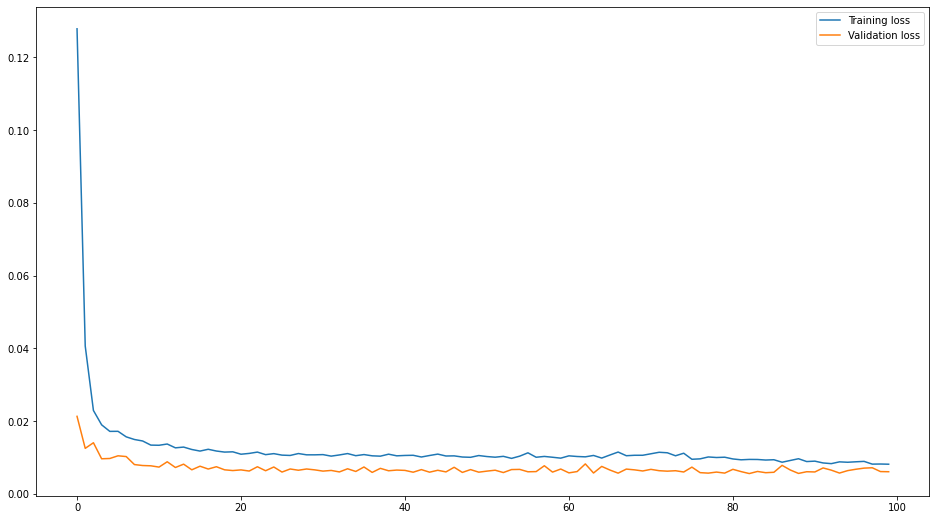

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
uni = data['Active_Power(kW)']
validatehori = uni.tail(48)

In [ ]:
validatehist = validatehori.values
scaler_val = preprocessing.MinMaxScaler()
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))

In [ ]:
val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))

In [ ]:
Predicted_results = enco_deco.predict(val_rescaled)

In [ ]:
Predicted_results

array([[[0.8623774 ],
        [0.8032402 ],
        [0.7432828 ],
        [0.6757848 ],
        [0.5972853 ],
        [0.5318136 ],
        [0.49373943],
        [0.47408763],
        [0.4659049 ],
        [0.46439222]]], dtype=float32)

In [ ]:
Predicted_inver_res = scaler_x.inverse_transform(Predicted_results[0])

In [ ]:
Predicted_inver_res

array([[25368.12 ],
       [23956.502],
       [22525.309],
       [20914.12 ],
       [19040.318],
       [17477.498],
       [16568.66 ],
       [16099.566],
       [15904.243],
       [15868.135]], dtype=float32)

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(validate,Predicted_inver_res)}')
    print(f'MAE is : {metrics.mean_absolute_error(validate,Predicted_inver_res)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(validate,Predicted_inver_res))}')
    print(f'MAPE is : {mean_absolute_percentage_error(validate,Predicted_inver_res)}')
    print(f'R2 is : {metrics.r2_score(validate,Predicted_inver_res)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validate,Predicted_inver_res)

Evaluation metric results:-
MSE is : 217196158.93376818
MAE is : 11858.96263671875
RMSE is : 14737.576426732048
MAPE is : 47.830991617702146
R2 is : -0.5500190899220319



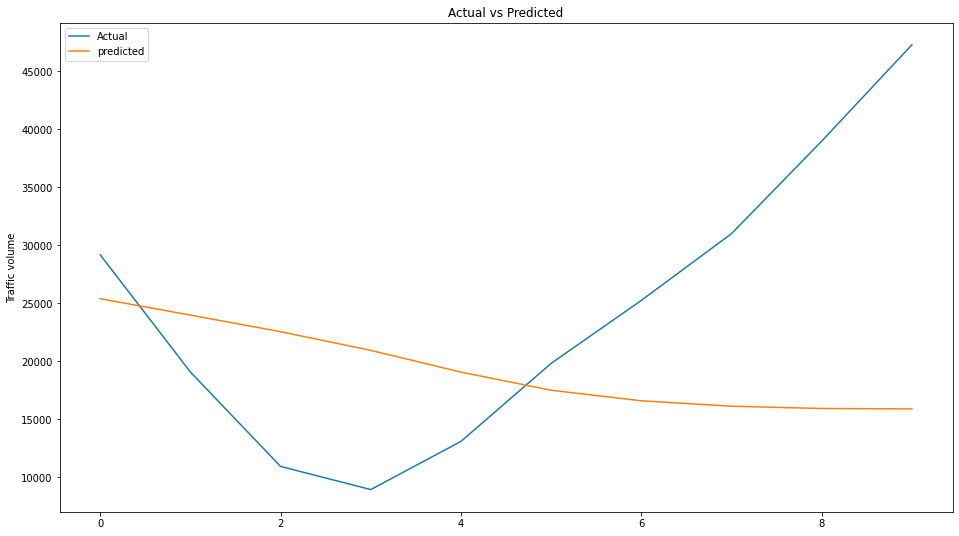

In [ ]:
plt.plot( list(validate))
plt.plot( list(Predicted_inver_res))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.rcParams["figure.figsize"] = [16,9]
plt.show()